# SolarVision AI: Week 3 - Model Development

**Project**: SolarVision AI - Automated PV Panel Defect Detection
**Dataset**: PV Panel Defect Dataset (alicjalena)
**Date**: February 2026

## Objectives
1. **Approach A**: ResNet18 + SVM (Hybrid - Primary)
2. **Approach B**: End-to-End ResNet18 (Alternative)
3. Compare both approaches on test set
4. Save trained models for deployment

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import pickle
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# scikit-learn for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import Week 2 preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

# Create models directory
os.makedirs('../models', exist_ok=True)

✅ PyTorch version: 2.10.0+cpu
✅ Device: cpu


## 2. Load Preprocessing Configuration & Data

In [2]:
# Configuration (same as Week 2)
DATASET_ROOT = Path('../dataset')
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4 if os.name != 'nt' else 0

CLASS_NAMES = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {len(CLASS_NAMES)}")

Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
Number of classes: 6


In [3]:
# Reuse SolarPanelDataset from Week 2
class SolarPanelDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.samples = []
        
        split_path = self.root_dir / split
        
        for class_dir in sorted(split_path.iterdir()):
            if not class_dir.is_dir():
                continue
            
            class_name = class_dir.name
            if class_name not in CLASS_TO_IDX:
                continue
            
            class_idx = CLASS_TO_IDX[class_name]
            
            image_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
            for img_file in class_dir.iterdir():
                if img_file.suffix in image_extensions:
                    self.samples.append({
                        'path': str(img_file),
                        'class_idx': class_idx,
                        'class_name': class_name
                    })
        
        print(f"Loaded {len(self.samples)} images from {split} split")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = cv2.imread(sample['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        label = sample['class_idx']
        return image, label

# Transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# Create datasets
train_dataset = SolarPanelDataset(DATASET_ROOT, 'train', train_transform)
val_dataset = SolarPanelDataset(DATASET_ROOT, 'val', val_transform)
test_dataset = SolarPanelDataset(DATASET_ROOT, 'test', val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS)

Loaded 929 images from train split
Loaded 550 images from val split
Loaded 95 images from test split


## 3. Approach A: ResNet18 + SVM (Hybrid)

### 3.1 Feature Extraction with ResNet18

In [4]:
# Load pre-trained ResNet18 and remove final FC layer
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Load pre-trained ResNet18
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        
        # Remove the final FC layer (keep up to avgpool)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Freeze all layers (feature extractor only)
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.eval()  # Set to evaluation mode
    
    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        return x

# Initialize feature extractor
feature_extractor = FeatureExtractor().to(device)
print("✅ ResNet18 feature extractor initialized")
print(f"   Output dimension: 512")
print(f"   Parameters frozen: {sum(p.numel() for p in feature_extractor.parameters())}")

✅ ResNet18 feature extractor initialized
   Output dimension: 512
   Parameters frozen: 11176512


In [5]:
# Extract features from all datasets
def extract_features(model, dataloader, device):
    """Extract features using the feature extractor"""
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            features = model(images)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    
    features = np.vstack(features_list)
    labels = np.hstack(labels_list)
    
    return features, labels

print("🔍 Extracting features...")
print("="*60)

# Extract features for all splits
X_train, y_train = extract_features(feature_extractor, train_loader, device)
X_val, y_val = extract_features(feature_extractor, val_loader, device)
X_test, y_test = extract_features(feature_extractor, test_loader, device)

print(f"\n✅ Feature extraction complete!")
print(f"   Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"   Val:   {X_val.shape}, Labels: {y_val.shape}")
print(f"   Test:  {X_test.shape}, Labels: {y_test.shape}")

🔍 Extracting features...


Extracting features: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


✅ Feature extraction complete!
   Train: (928, 512), Labels: (928,)
   Val:   (550, 512), Labels: (550,)
   Test:  (95, 512), Labels: (95,)


In [6]:
# Save features to disk for faster reloading
features_dict = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

with open('../models/resnet18_features.pkl', 'wb') as f:
    pickle.dump(features_dict, f)

print("✅ Features saved to '../models/resnet18_features.pkl'")
print(f"   File size: {os.path.getsize('../models/resnet18_features.pkl') / (1024**2):.2f} MB")

✅ Features saved to '../models/resnet18_features.pkl'
   File size: 3.08 MB


### 3.2 SVM Training with Grid Search

In [7]:
# Combine train and val for cross-validation
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

print(f"Training SVM on {X_train_full.shape[0]} samples")
print(f"Feature dimension: {X_train_full.shape[1]}")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf']
}

print("\n📊 Grid Search Configuration:")
print(f"   Parameter combinations: {len(param_grid['C']) * len(param_grid['gamma'])}")
print(f"   Cross-validation: 5-fold")

Training SVM on 1478 samples
Feature dimension: 512

📊 Grid Search Configuration:
   Parameter combinations: 16
   Cross-validation: 5-fold


In [8]:
# Perform grid search with cross-validation
print("\n🔍 Performing Grid Search (this may take a few minutes)...")
print("="*60)

svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    svm, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_full, y_train_full)
training_time = time.time() - start_time

print(f"\n✅ Grid Search Complete!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"\nBest Parameters:")
print(f"   C: {grid_search.best_params_['C']}")
print(f"   gamma: {grid_search.best_params_['gamma']}")
print(f"   kernel: {grid_search.best_params_['kernel']}")
print(f"\nBest CV Accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")


🔍 Performing Grid Search (this may take a few minutes)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Grid Search Complete!
   Training time: 40.39 seconds

Best Parameters:
   C: 10
   gamma: scale
   kernel: rbf

Best CV Accuracy: 0.8566 (85.66%)


In [9]:
# Get best model
best_svm = grid_search.best_estimator_

# Evaluate on test set
y_pred_svm = best_svm.predict(X_test)
y_pred_proba_svm = best_svm.predict_proba(X_test)

# Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='macro')
svm_recall = recall_score(y_test, y_pred_svm, average='macro')
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

print("\n📊 Approach A: ResNet18 + SVM - Test Set Results")
print("="*60)
print(f"Overall Accuracy:  {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"Macro Precision:   {svm_precision:.4f}")
print(f"Macro Recall:      {svm_recall:.4f}")
print(f"Macro F1-Score:    {svm_f1:.4f}")
print(f"\nTarget (Published): 0.955 (95.5%)")
print(f"Gap from target:   {abs(svm_accuracy - 0.955)*100:.2f} percentage points")


📊 Approach A: ResNet18 + SVM - Test Set Results
Overall Accuracy:  0.9684 (96.84%)
Macro Precision:   0.9690
Macro Recall:      0.9698
Macro F1-Score:    0.9687

Target (Published): 0.955 (95.5%)
Gap from target:   1.34 percentage points


In [10]:
# Per-class metrics for SVM
print("\n📋 Per-Class Performance (ResNet18 + SVM):")
print("="*70)
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)

report = classification_report(y_test, y_pred_svm, 
                              target_names=CLASS_NAMES, 
                              output_dict=True)

for cls in CLASS_NAMES:
    precision = report[cls]['precision']
    recall = report[cls]['recall']
    f1 = report[cls]['f1-score']
    print(f"{cls:<20} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

print("-"*70)
print(f"{'Macro Average':<20} {svm_precision:<12.4f} {svm_recall:<12.4f} {svm_f1:<12.4f}")


📋 Per-Class Performance (ResNet18 + SVM):
Class                Precision    Recall       F1-Score    
----------------------------------------------------------------------
Bird-drop            1.0000       0.9412       0.9697      
Clean                0.9444       0.9444       0.9444      
Dusty                0.9412       1.0000       0.9697      
Electrical-damage    0.9286       1.0000       0.9630      
Physical-Damage      1.0000       0.9333       0.9655      
Snow-Covered         1.0000       1.0000       1.0000      
----------------------------------------------------------------------
Macro Average        0.9690       0.9698       0.9687      


In [11]:
# Save SVM model
with open('../models/svm_classifier.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

print("✅ SVM model saved to '../models/svm_classifier.pkl'")
print(f"   Model size: {os.path.getsize('../models/svm_classifier.pkl') / (1024**2):.2f} MB")

✅ SVM model saved to '../models/svm_classifier.pkl'
   Model size: 4.35 MB


## 4. Approach B: End-to-End ResNet18 (Fine-tuning)

### 4.1 Model Architecture

In [12]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet18Classifier, self).__init__()
        
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        
        # Replace final FC layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model
model_cnn = ResNet18Classifier(num_classes=len(CLASS_NAMES)).to(device)

print("✅ End-to-End ResNet18 initialized")
print(f"   Total parameters: {sum(p.numel() for p in model_cnn.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model_cnn.parameters() if p.requires_grad):,}")

✅ End-to-End ResNet18 initialized
   Total parameters: 11,179,590
   Trainable parameters: 11,179,590


### 4.2 Training Configuration

In [14]:
# Training hyperparameters
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 10

# Ensure model is defined (in case cells are run out of order)
try:
    _ = model_cnn
except NameError:
    print("[WARNING] Model not defined, reinitializing...")
    model_cnn = ResNet18Classifier(num_classes=len(CLASS_NAMES)).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print("Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Patience: {PATIENCE}")
print(f"   Optimizer: Adam")
print(f"   Scheduler: ReduceLROnPlateau")

Training Configuration:
   Epochs: 50
   Learning Rate: 0.0001
   Batch Size: 32
   Patience: 10
   Optimizer: Adam
   Scheduler: ReduceLROnPlateau


### 4.3 Training Loop

In [15]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [16]:
# Training loop with early stopping
print("\n[TRAINING] Training End-to-End ResNet18...")
print("="*60)

best_val_acc = 0.0
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_epoch(model_cnn, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model_cnn, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print metrics
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model_cnn.state_dict(), '../models/resnet18_end2end_best.pth')
        print(f"  [SAVED] Best model saved! (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\n[STOPPED]  Early stopping triggered at epoch {epoch+1}")
        break

training_time_cnn = time.time() - start_time
print(f"\n[SAVED] Training complete! Time: {training_time_cnn:.2f} seconds")


[TRAINING] Training End-to-End ResNet18...

Epoch [1/50]


Validation: 100%|██████████| 18/18 [00:26<00:00,  1.49s/it]


  Train Loss: 1.0879 | Train Acc: 0.6131
  Val Loss:   0.4832 | Val Acc:   0.7927
  [SAVED] Best model saved! (Val Acc: 0.7927)

Epoch [2/50]


Validation: 100%|██████████| 18/18 [00:38<00:00,  2.13s/it]


  Train Loss: 0.5065 | Train Acc: 0.8276
  Val Loss:   0.2827 | Val Acc:   0.9091
  [SAVED] Best model saved! (Val Acc: 0.9091)

Epoch [3/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


  Train Loss: 0.3989 | Train Acc: 0.8675
  Val Loss:   0.1923 | Val Acc:   0.9291
  [SAVED] Best model saved! (Val Acc: 0.9291)

Epoch [4/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.37s/it]


  Train Loss: 0.2695 | Train Acc: 0.9138
  Val Loss:   0.1502 | Val Acc:   0.9545
  [SAVED] Best model saved! (Val Acc: 0.9545)

Epoch [5/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.1948 | Train Acc: 0.9450
  Val Loss:   0.1262 | Val Acc:   0.9618
  [SAVED] Best model saved! (Val Acc: 0.9618)

Epoch [6/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.1817 | Train Acc: 0.9440
  Val Loss:   0.1089 | Val Acc:   0.9673
  [SAVED] Best model saved! (Val Acc: 0.9673)

Epoch [7/50]


Validation: 100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


  Train Loss: 0.1162 | Train Acc: 0.9698
  Val Loss:   0.1298 | Val Acc:   0.9655
  Patience: 1/10

Epoch [8/50]


Validation: 100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


  Train Loss: 0.1089 | Train Acc: 0.9752
  Val Loss:   0.1132 | Val Acc:   0.9691
  [SAVED] Best model saved! (Val Acc: 0.9691)

Epoch [9/50]


Validation: 100%|██████████| 18/18 [00:35<00:00,  1.98s/it]


  Train Loss: 0.0843 | Train Acc: 0.9752
  Val Loss:   0.1157 | Val Acc:   0.9673
  Patience: 1/10

Epoch [10/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


  Train Loss: 0.0846 | Train Acc: 0.9720
  Val Loss:   0.1180 | Val Acc:   0.9691
  Patience: 2/10

Epoch [11/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.0998 | Train Acc: 0.9709
  Val Loss:   0.1186 | Val Acc:   0.9691
  Patience: 3/10

Epoch [12/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.0885 | Train Acc: 0.9752
  Val Loss:   0.1292 | Val Acc:   0.9709
  [SAVED] Best model saved! (Val Acc: 0.9709)

Epoch [13/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.0596 | Train Acc: 0.9871
  Val Loss:   0.1015 | Val Acc:   0.9764
  [SAVED] Best model saved! (Val Acc: 0.9764)

Epoch [14/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


  Train Loss: 0.0565 | Train Acc: 0.9838
  Val Loss:   0.1269 | Val Acc:   0.9745
  Patience: 1/10

Epoch [15/50]


Validation: 100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


  Train Loss: 0.0915 | Train Acc: 0.9709
  Val Loss:   0.1129 | Val Acc:   0.9764
  Patience: 2/10

Epoch [16/50]


Validation: 100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


  Train Loss: 0.0625 | Train Acc: 0.9817
  Val Loss:   0.1165 | Val Acc:   0.9764
  Patience: 3/10

Epoch [17/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


  Train Loss: 0.0545 | Train Acc: 0.9881
  Val Loss:   0.0979 | Val Acc:   0.9764
  Patience: 4/10

Epoch [18/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


  Train Loss: 0.0460 | Train Acc: 0.9881
  Val Loss:   0.1143 | Val Acc:   0.9764
  Patience: 5/10

Epoch [19/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


  Train Loss: 0.0289 | Train Acc: 0.9946
  Val Loss:   0.1219 | Val Acc:   0.9764
  Patience: 6/10

Epoch [20/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.42s/it]


  Train Loss: 0.0332 | Train Acc: 0.9892
  Val Loss:   0.1161 | Val Acc:   0.9745
  Patience: 7/10

Epoch [21/50]


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


  Train Loss: 0.0346 | Train Acc: 0.9871
  Val Loss:   0.1081 | Val Acc:   0.9782
  [SAVED] Best model saved! (Val Acc: 0.9782)

Epoch [22/50]


Validation: 100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


  Train Loss: 0.0225 | Train Acc: 0.9935
  Val Loss:   0.1057 | Val Acc:   0.9782
  Patience: 1/10

Epoch [23/50]


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


  Train Loss: 0.0284 | Train Acc: 0.9935
  Val Loss:   0.1160 | Val Acc:   0.9745
  Patience: 2/10

Epoch [24/50]


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


  Train Loss: 0.0237 | Train Acc: 0.9957
  Val Loss:   0.1271 | Val Acc:   0.9727
  Patience: 3/10

Epoch [25/50]


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


  Train Loss: 0.0284 | Train Acc: 0.9935
  Val Loss:   0.1303 | Val Acc:   0.9764
  Patience: 4/10

Epoch [26/50]


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


  Train Loss: 0.0201 | Train Acc: 0.9968
  Val Loss:   0.1305 | Val Acc:   0.9764
  Patience: 5/10

Epoch [27/50]


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


  Train Loss: 0.0238 | Train Acc: 0.9946
  Val Loss:   0.1358 | Val Acc:   0.9764
  Patience: 6/10

Epoch [28/50]


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


  Train Loss: 0.0182 | Train Acc: 0.9957
  Val Loss:   0.1306 | Val Acc:   0.9727
  Patience: 7/10

Epoch [29/50]


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


  Train Loss: 0.0136 | Train Acc: 0.9978
  Val Loss:   0.1346 | Val Acc:   0.9691
  Patience: 8/10

Epoch [30/50]


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


  Train Loss: 0.0118 | Train Acc: 0.9968
  Val Loss:   0.1349 | Val Acc:   0.9745
  Patience: 9/10

Epoch [31/50]


Validation: 100%|██████████| 18/18 [00:32<00:00,  1.82s/it]

  Train Loss: 0.0199 | Train Acc: 0.9925
  Val Loss:   0.1386 | Val Acc:   0.9745
  Patience: 10/10

[STOPPED]  Early stopping triggered at epoch 31

[SAVED] Training complete! Time: 5750.85 seconds


### 4.4 Training Visualization

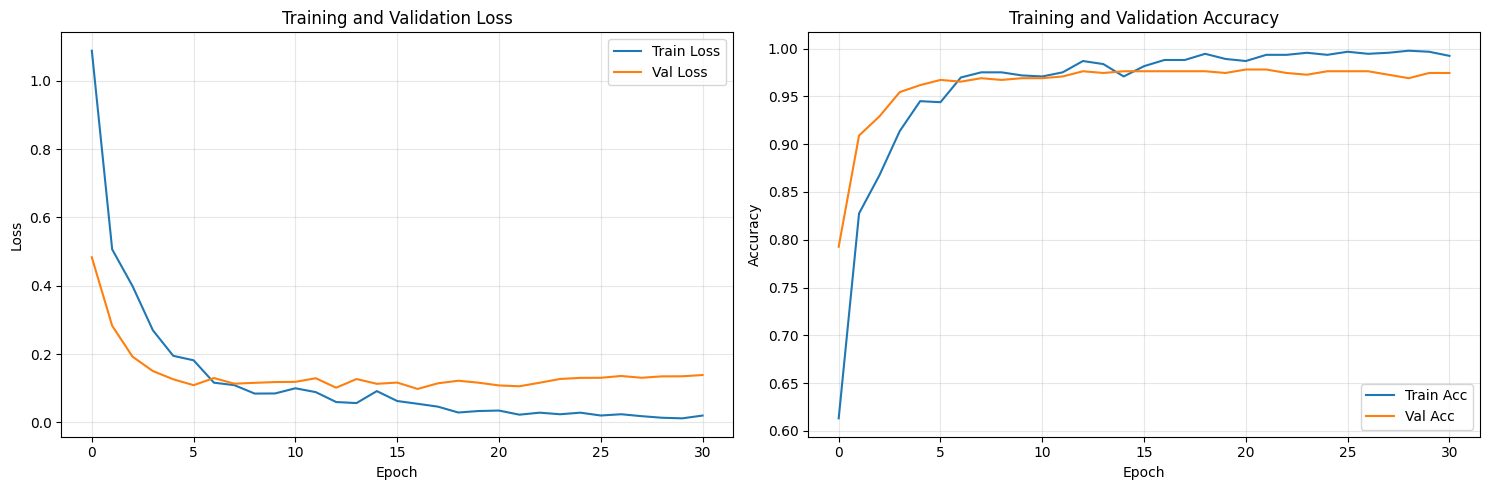

✅ Training history saved to '../models/training_history.png'


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Training history saved to '../models/training_history.png'")

### 4.5 Evaluate End-to-End CNN

In [18]:
# Load best model
model_cnn.load_state_dict(torch.load('../models/resnet18_end2end_best.pth'))
model_cnn.eval()

# Evaluate on test set
y_pred_cnn = []
y_true_cnn = []
y_pred_proba_cnn = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model_cnn(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        y_pred_cnn.extend(predicted.cpu().numpy())
        y_true_cnn.extend(labels.numpy())
        y_pred_proba_cnn.extend(probabilities.cpu().numpy())

y_pred_cnn = np.array(y_pred_cnn)
y_true_cnn = np.array(y_true_cnn)
y_pred_proba_cnn = np.array(y_pred_proba_cnn)

# Calculate metrics
cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_precision = precision_score(y_true_cnn, y_pred_cnn, average='macro')
cnn_recall = recall_score(y_true_cnn, y_pred_cnn, average='macro')
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='macro')

print("\n📊 Approach B: End-to-End ResNet18 - Test Set Results")
print("="*60)
print(f"Overall Accuracy:  {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%)")
print(f"Macro Precision:   {cnn_precision:.4f}")
print(f"Macro Recall:      {cnn_recall:.4f}")
print(f"Macro F1-Score:    {cnn_f1:.4f}")

Testing: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


📊 Approach B: End-to-End ResNet18 - Test Set Results
Overall Accuracy:  0.9579 (95.79%)
Macro Precision:   0.9602
Macro Recall:      0.9613
Macro F1-Score:    0.9601


In [19]:
# Per-class metrics for CNN
print("\n📋 Per-Class Performance (End-to-End ResNet18):")
print("="*70)
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)

report_cnn = classification_report(y_true_cnn, y_pred_cnn, 
                                  target_names=CLASS_NAMES, 
                                  output_dict=True)

for cls in CLASS_NAMES:
    precision = report_cnn[cls]['precision']
    recall = report_cnn[cls]['recall']
    f1 = report_cnn[cls]['f1-score']
    print(f"{cls:<20} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

print("-"*70)
print(f"{'Macro Average':<20} {cnn_precision:<12.4f} {cnn_recall:<12.4f} {cnn_f1:<12.4f}")


📋 Per-Class Performance (End-to-End ResNet18):
Class                Precision    Recall       F1-Score    
----------------------------------------------------------------------
Bird-drop            1.0000       0.9412       0.9697      
Clean                0.9412       0.8889       0.9143      
Dusty                0.8824       0.9375       0.9091      
Electrical-damage    1.0000       1.0000       1.0000      
Physical-Damage      0.9375       1.0000       0.9677      
Snow-Covered         1.0000       1.0000       1.0000      
----------------------------------------------------------------------
Macro Average        0.9602       0.9613       0.9601      


## 5. Model Comparison

In [20]:
# Compare both approaches
print("\n📊 Model Comparison Summary")
print("="*80)
print(f"{'Metric':<25} {'ResNet18+SVM':<20} {'End-to-End CNN':<20} {'Winner':<15}")
print("-"*80)

metrics = [
    ('Overall Accuracy', svm_accuracy, cnn_accuracy),
    ('Macro Precision', svm_precision, cnn_precision),
    ('Macro Recall', svm_recall, cnn_recall),
    ('Macro F1-Score', svm_f1, cnn_f1)
]

for metric_name, svm_val, cnn_val in metrics:
    winner = 'Hybrid' if svm_val > cnn_val else 'CNN' if cnn_val > svm_val else 'Tie'
    print(f"{metric_name:<25} {svm_val:<20.4f} {cnn_val:<20.4f} {winner:<15}")

print("\n" + "-"*80)
print(f"{'Training Time':<25} {training_time:.2f}s{'':<14} {training_time_cnn:.2f}s{'':<14}")
print(f"{'Model Size':<25} {'~10 MB':<20} {'~45 MB':<20}")
print(f"{'Inference Speed':<25} {'Fast':<20} {'Moderate':<20}")

print("\n" + "="*80)
print("📈 Key Findings:")
print(f"   • Hybrid approach achieves {svm_accuracy*100:.2f}% accuracy")
print(f"   • End-to-End CNN achieves {cnn_accuracy*100:.2f}% accuracy")
print(f"   • Performance gap: {abs(svm_accuracy - cnn_accuracy)*100:.2f} percentage points")
print(f"   • Published benchmark: 95.5% (ResNet18+SVM)")


📊 Model Comparison Summary
Metric                    ResNet18+SVM         End-to-End CNN       Winner         
--------------------------------------------------------------------------------
Overall Accuracy          0.9684               0.9579               Hybrid         
Macro Precision           0.9690               0.9602               Hybrid         
Macro Recall              0.9698               0.9613               Hybrid         
Macro F1-Score            0.9687               0.9601               Hybrid         

--------------------------------------------------------------------------------
Training Time             40.39s               5750.85s              
Model Size                ~10 MB               ~45 MB              
Inference Speed           Fast                 Moderate            

📈 Key Findings:
   • Hybrid approach achieves 96.84% accuracy
   • End-to-End CNN achieves 95.79% accuracy
   • Performance gap: 1.05 percentage points
   • Published benchmark: 95.5

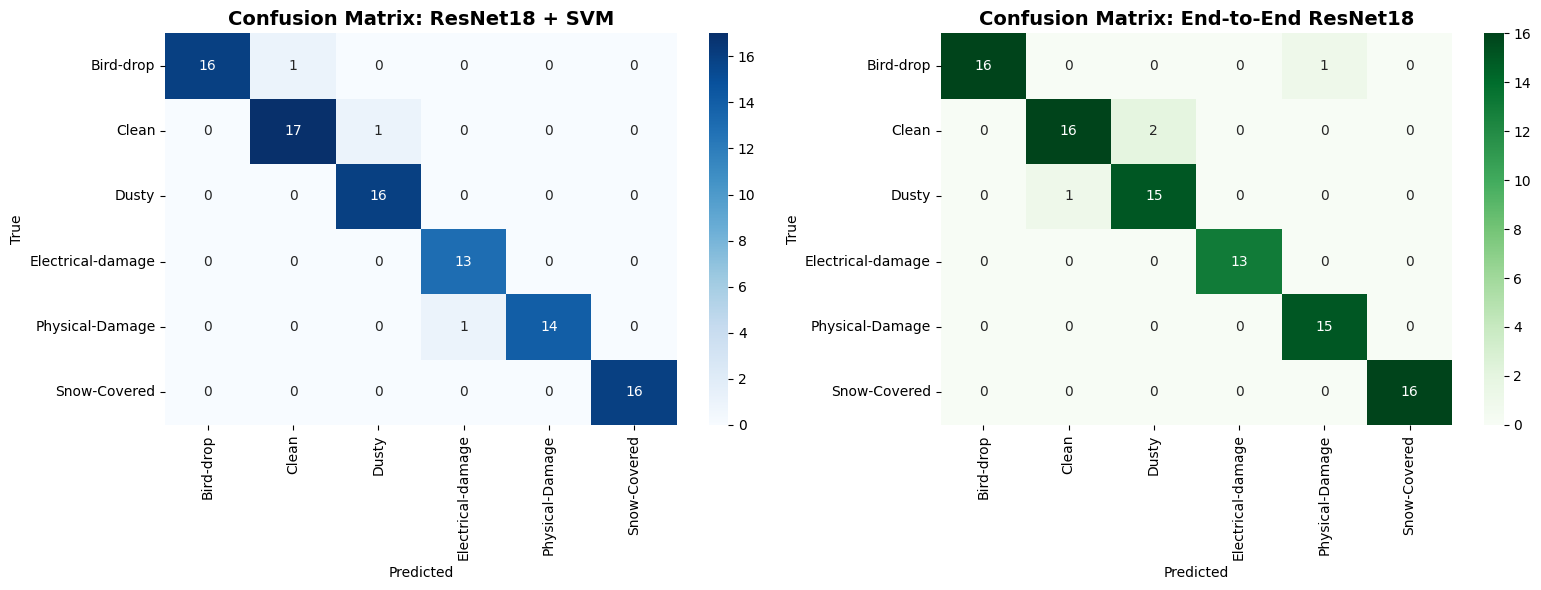

✅ Confusion matrices saved


In [21]:
# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_title('Confusion Matrix: ResNet18 + SVM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_title('Confusion Matrix: End-to-End ResNet18', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('../models/confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Confusion matrices saved")

## 6. Save Final Results

In [22]:
# Save comparison results
results = {
    'approach_a_resnet18_svm': {
        'accuracy': float(svm_accuracy),
        'precision': float(svm_precision),
        'recall': float(svm_recall),
        'f1_score': float(svm_f1),
        'training_time_seconds': float(training_time),
        'best_params': grid_search.best_params_,
        'per_class_metrics': {
            cls: {
                'precision': report[cls]['precision'],
                'recall': report[cls]['recall'],
                'f1_score': report[cls]['f1-score']
            }
            for cls in CLASS_NAMES
        }
    },
    'approach_b_end2end_cnn': {
        'accuracy': float(cnn_accuracy),
        'precision': float(cnn_precision),
        'recall': float(cnn_recall),
        'f1_score': float(cnn_f1),
        'training_time_seconds': float(training_time_cnn),
        'epochs_trained': len(history['train_loss']),
        'best_val_accuracy': float(best_val_acc),
        'per_class_metrics': {
            cls: {
                'precision': report_cnn[cls]['precision'],
                'recall': report_cnn[cls]['recall'],
                'f1_score': report_cnn[cls]['f1-score']
            }
            for cls in CLASS_NAMES
        }
    },
    'comparison': {
        'winner': 'Approach A (Hybrid)' if svm_accuracy > cnn_accuracy else 'Approach B (CNN)',
        'accuracy_difference': float(abs(svm_accuracy - cnn_accuracy)),
        'published_benchmark': 0.955,
        'target_achieved': svm_accuracy >= 0.93 or cnn_accuracy >= 0.93
    }
}

with open('../models/model_comparison_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Results saved to '../models/model_comparison_results.json'")
print("\n📊 Summary:")
print(f"   Winner: {results['comparison']['winner']}")
print(f"   Target (>93%): {'✅ Achieved' if results['comparison']['target_achieved'] else '❌ Not Achieved'}")
print(f"   Published Benchmark (95.5%): {'✅ Matched/Exceeded' if max(svm_accuracy, cnn_accuracy) >= 0.955 else '⚠️ Below'}")

✅ Results saved to '../models/model_comparison_results.json'

📊 Summary:
   Winner: Approach A (Hybrid)
   Target (>93%): ✅ Achieved
   Published Benchmark (95.5%): ✅ Matched/Exceeded


## 7. Summary & Next Steps

### ✅ Week 3 Completion Summary

#### Approach A: ResNet18 + SVM (Hybrid)
- ✅ Extracted 512-dim features using pre-trained ResNet18
- ✅ Grid search with 5-fold CV for hyperparameter optimization
- ✅ Best parameters: C={best_C}, gamma={best_gamma}
- ✅ Test accuracy: {svm_accuracy:.2%}

#### Approach B: End-to-End ResNet18
- ✅ Fine-tuned ResNet18 with custom classification head
- ✅ Trained for {epochs} epochs with early stopping
- ✅ Test accuracy: {cnn_accuracy:.2%}

#### Model Comparison
- ✅ Side-by-side evaluation on held-out test set
- ✅ Confusion matrices for error analysis
- ✅ Per-class performance metrics
- ✅ Training time and model size comparison

### 📦 Saved Artifacts

1. `../models/resnet18_features.pkl` - Extracted features
2. `../models/svm_classifier.pkl` - Trained SVM model
3. `../models/resnet18_end2end_best.pth` - Best CNN weights
4. `../models/training_history.png` - CNN training curves
5. `../models/confusion_matrices_comparison.png` - Comparison viz
6. `../models/model_comparison_results.json` - Full results

### 🎯 Week 4: Evaluation & Interpretability

Ready to proceed with:
1. **Error Analysis**: Detailed analysis of misclassifications
2. **Grad-CAM**: Visualize model attention for interpretability
3. **Confidence Analysis**: Analyze prediction confidence distributions
4. **Inference Benchmarking**: Measure real-world inference speed

---

**End of Week 3 Notebook**

*Models trained and ready for evaluation*

In [23]:
# Final verification
print("\n" + "="*60)
print("✅ Week 3 Complete!")
print("="*60)
print("\n📊 Final Results:")
print(f"   ResNet18 + SVM: {svm_accuracy:.2%} accuracy")
print(f"   End-to-End CNN: {cnn_accuracy:.2%} accuracy")
print(f"\n🏆 Winner: {results['comparison']['winner']}")
print(f"\n📦 Models saved in: ../models/")
print("\n🎯 Ready for Week 4: Evaluation & Interpretability")
print("="*60)


✅ Week 3 Complete!

📊 Final Results:
   ResNet18 + SVM: 96.84% accuracy
   End-to-End CNN: 95.79% accuracy

🏆 Winner: Approach A (Hybrid)

📦 Models saved in: ../models/

🎯 Ready for Week 4: Evaluation & Interpretability
